In [2]:
# toy experiment to compare mco-vae with vae, aae and wae
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [3]:
import matplotlib.pyplot as plt
from utils import * # for visualization
visualize_settings['x_y_samples'] = (1000,1000)

In [4]:
class vae(nn.Module):
    def __init__(self, num_classes=8, num_batch=16, dim_z=2, dim_hidden=8, nsamples=8):
        super().__init__()
        self.num_classes, self.dim_z, self.dim_hidden = num_classes, dim_z, dim_hidden
        self.nsamples, self.num_batch = nsamples, num_batch
        self.post_mean = nn.Parameter(torch.zeros(num_classes*num_batch, dim_z))
        self.post_logvar = nn.Parameter(torch.zeros(num_classes*num_batch, dim_z))
        self.classifier = nn.Sequential(
            nn.Linear(dim_z, dim_hidden),
            nn.Sigmoid(),
            nn.Linear(dim_hidden, num_classes*num_batch),
        )
        self.index_batch = 0
        self.label_cls = torch.arange(num_classes*num_batch).view(num_batch, num_classes).cuda()
    
    def forward(self):
        self.index_batch = (self.index_batch+1)%self.num_batch
        mean = self.post_mean[self.index_batch*self.num_classes:(self.index_batch+1)*self.num_classes,:]
        logvar = self.post_logvar[self.index_batch*self.num_classes:(self.index_batch+1)*self.num_classes,:]
        loss_kld = self.loss_kld(mean, logvar)
        loss_cls = self.loss_cls(mean, logvar)
        return loss_kld, loss_cls
    
    def post_sampling(self, mean, logvar, nsamples=1):
        expanded_mean = mean.unsqueeze(1).repeat(1, nsamples, 1)
        expanded_logvar = logvar.unsqueeze(1).repeat(1, nsamples, 1)
        epsilons = torch.zeros_like(expanded_mean).normal_()
        zs = expanded_mean + torch.exp(expanded_logvar*0.5)*epsilons
        return zs
    
    def prior_sampling(self, mean, logvar, nsamples=1):
        mean, logvar = torch.zeros_like(mean), torch.zeros_like(logvar)
        expanded_mean = mean.unsqueeze(1).repeat(1, nsamples, 1)
        expanded_logvar = logvar.unsqueeze(1).repeat(1, nsamples, 1)
        epsilons = torch.zeros_like(expanded_mean).normal_()
        zs = expanded_mean + torch.exp(expanded_logvar*0.5)*epsilons
        return zs
    
    def loss_kld(self, mean, logvar):
        loss_kld = 0.5 * (mean.pow(2) + logvar.exp() - logvar - 1).sum(dim=1).mean(dim=0)
        return loss_kld
    
    def loss_cls(self, mean, logvar):
        zs = self.post_sampling(mean, logvar).squeeze(1)
        loss_cls = F.cross_entropy(self.classifier(zs),
                                   self.label_cls[self.index_batch,:])
        return loss_cls

In [5]:
class ae(vae):
    def __init__(self):
        super().__init__()
        
    def loss_kld(self, mean, logvar):
        loss_kld = torch.zeros_like(mean).mean()
        return loss_kld

In [6]:
class aae(vae):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(self.dim_z, self.dim_hidden),
            nn.Sigmoid(),
            nn.Linear(self.dim_hidden, self.dim_hidden),
            nn.Sigmoid(),
            nn.Linear(self.dim_hidden, 2),
        )
        self.label_dis = torch.cat([torch.ones_like(self.label_cls[self.index_batch,:]).repeat(self.nsamples),
                                    torch.zeros_like(self.label_cls[self.index_batch,:]).repeat(self.nsamples)], dim=0)
    
    def discriminator_detach_forward(self, zs):
        w1, b1 = self.discriminator[0].weight.detach(), self.discriminator[0].bias.detach()
        sigmoid1 = self.discriminator[1]
        w2, b2 = self.discriminator[2].weight.detach(), self.discriminator[2].bias.detach()
        sigmoid2 = self.discriminator[3]
        w3, b3 = self.discriminator[4].weight.detach(), self.discriminator[4].bias.detach()
        #return torch.mm(sigmoid(torch.mm(zs, w1.T) + b1[None,:]), w2.T) + b2[None,:]
        return torch.mm(sigmoid2(torch.mm(sigmoid1(torch.mm(zs, w1.T) + b1[None,:]), w2.T) + b2[None,:]), w3.T) + b3[None,:]
    
    def loss_kld(self, mean, logvar):
        prior_zs = self.prior_sampling(mean, logvar, self.nsamples).view(self.num_classes*self.nsamples, self.dim_z)
        post_zs = self.post_sampling(mean, logvar, self.nsamples).view(self.num_classes*self.nsamples, self.dim_z)
        zs = torch.cat([prior_zs, post_zs], dim=0)
        loss_dis = F.cross_entropy(self.discriminator(zs.detach()), self.label_dis)
        loss_gen = F.cross_entropy(self.discriminator_detach_forward(post_zs),
                                   torch.ones_like(self.label_cls[self.index_batch,:]).repeat(self.nsamples))
        loss_kld = loss_gen + loss_dis
        return loss_kld

In [7]:
class wae(vae): # wae-mmd, https://github.com/1Konny/WAE-pytorch
    def __init__(self):
        super().__init__()
    
    def loss_kld(self, mean, logvar):
        def im_kernel_sum(z1, z2, z_var, exclude_diag=True):
            r"""Calculate sum of sample-wise measures of inverse multiquadratics kernel described in the WAE paper.
            Args:
                z1 (Tensor): batch of samples from a multivariate gaussian distribution \
                    with scalar variance of z_var.
                z2 (Tensor): batch of samples from another multivariate gaussian distribution \
                    with scalar variance of z_var.
                exclude_diag (bool): whether to exclude diagonal kernel measures before sum it all.
            """
            assert z1.size() == z2.size()
            assert z1.ndimension() == 2
            z_dim = z1.size(1)
            C = 2*z_dim*z_var
            z11 = z1.unsqueeze(1).repeat(1, z2.size(0), 1)
            z22 = z2.unsqueeze(0).repeat(z1.size(0), 1, 1)
            kernel_matrix = C/(1e-9+C+(z11-z22).pow(2).sum(2))
            kernel_sum = kernel_matrix.sum()
            # numerically identical to the formulation. but..
            if exclude_diag:
                kernel_sum -= kernel_matrix.diag().sum()
            return kernel_sum
        def mmd(z_tilde, z, z_var=1):
            r"""Calculate maximum mean discrepancy described in the WAE paper.
            Args:
                z_tilde (Tensor): samples from deterministic non-random encoder Q(Z|X).
                    2D Tensor(batch_size x dimension).
                z (Tensor): samples from prior distributions. same shape with z_tilde.
                z_var (Number): scalar variance of isotropic gaussian prior P(Z).
            """
            assert z_tilde.size() == z.size()
            assert z.ndimension() == 2
            n = z.size(0)
            out = im_kernel_sum(z, z, z_var, exclude_diag=True).div(n*(n-1)) + \
                  im_kernel_sum(z_tilde, z_tilde, z_var, exclude_diag=True).div(n*(n-1)) + \
                  -im_kernel_sum(z, z_tilde, z_var, exclude_diag=False).div(n*n).mul(2)
            return out
        prior_zs = self.prior_sampling(mean, logvar, self.nsamples).view(self.num_classes*self.nsamples, self.dim_z)
        post_zs = self.post_sampling(mean, logvar, self.nsamples).view(self.num_classes*self.nsamples, self.dim_z)
        loss_kld = mmd(prior_zs, post_zs)
        return loss_kld

In [8]:
class dgvae(vae):
    def __init__(self):
        super().__init__()
        
    def loss_kld(self, mean, logvar):
        post_zs = self.post_sampling(mean, logvar, self.nsamples).view(self.num_classes*self.nsamples, self.dim_z)
        post_zs = post_zs.unsqueeze(0).repeat(self.num_classes,1,1)
        def GaussianPDF(mean, logvar, z):
            mean, logvar = mean.unsqueeze(-2), logvar.unsqueeze(-2)
            return 1/(np.sqrt(2*np.pi)*torch.exp(logvar*0.5)) * torch.exp(-((z-mean)**2) / (2*torch.exp(logvar)))
        qzs = GaussianPDF(mean, logvar, post_zs)
        logq = qzs.mean(dim=0).log().sum(dim=1).mean(dim=0)
        pzs = GaussianPDF(torch.zeros_like(mean), torch.zeros_like(logvar), post_zs)
        logp = pzs.mean(dim=0).log().sum(dim=1).mean(dim=0)
        loss_kld = logq-logp
        return loss_kld

In [9]:
def visualize_latent(model, pltm, name=None):
    for i,mode in enumerate(["aggregated", "center"]):
        visualize2D_posterior_distribution(
            model.post_mean.cpu().detach().numpy(), model.post_logvar.cpu().detach().numpy(),
            pltm.plt, pltm.subplot(), mode, (0,1))
        if name is not None and i==0:
            pltm.plt.ylabel(name, fontsize=25)
        if pltm.index <= pltm.columns:
            pltm.plt.title(f"{int((pltm.index+1)/2)*100} steps", fontsize=20)

In [10]:
def exp(model_class, pltm=None, names=None):
    if type(model_class) is list:
        pltm = pltManager(plt, columns=10, lines=len(model_class))
        for model_class_,name in tqdm(zip(model_class,names),total=len(model_class)):
            exp(model_class_, pltm, name)
        return
    model = model_class().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    pltm = pltm if pltm else pltManager(plt, columns=10, lines=1)
    for step in range(500):
        loss_kld, loss_cls = model()
        (loss_kld + loss_cls).backward()
        optimizer.step()
        optimizer.zero_grad()
        if (step+1) % 100 == 0:
            #print(f"step {step}: loss_kld={loss_kld:.2f}, loss_cls={loss_cls:.2f}")
            if step+1 == 100 and type(names) is str:
                visualize_latent(model, pltm, names)
            else:
                visualize_latent(model, pltm)
    pltm.plt.savefig(f"toy_experiment.png", dpi=300)

Automatic pdb calling has been turned ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:20<00:00, 16.01s/it]


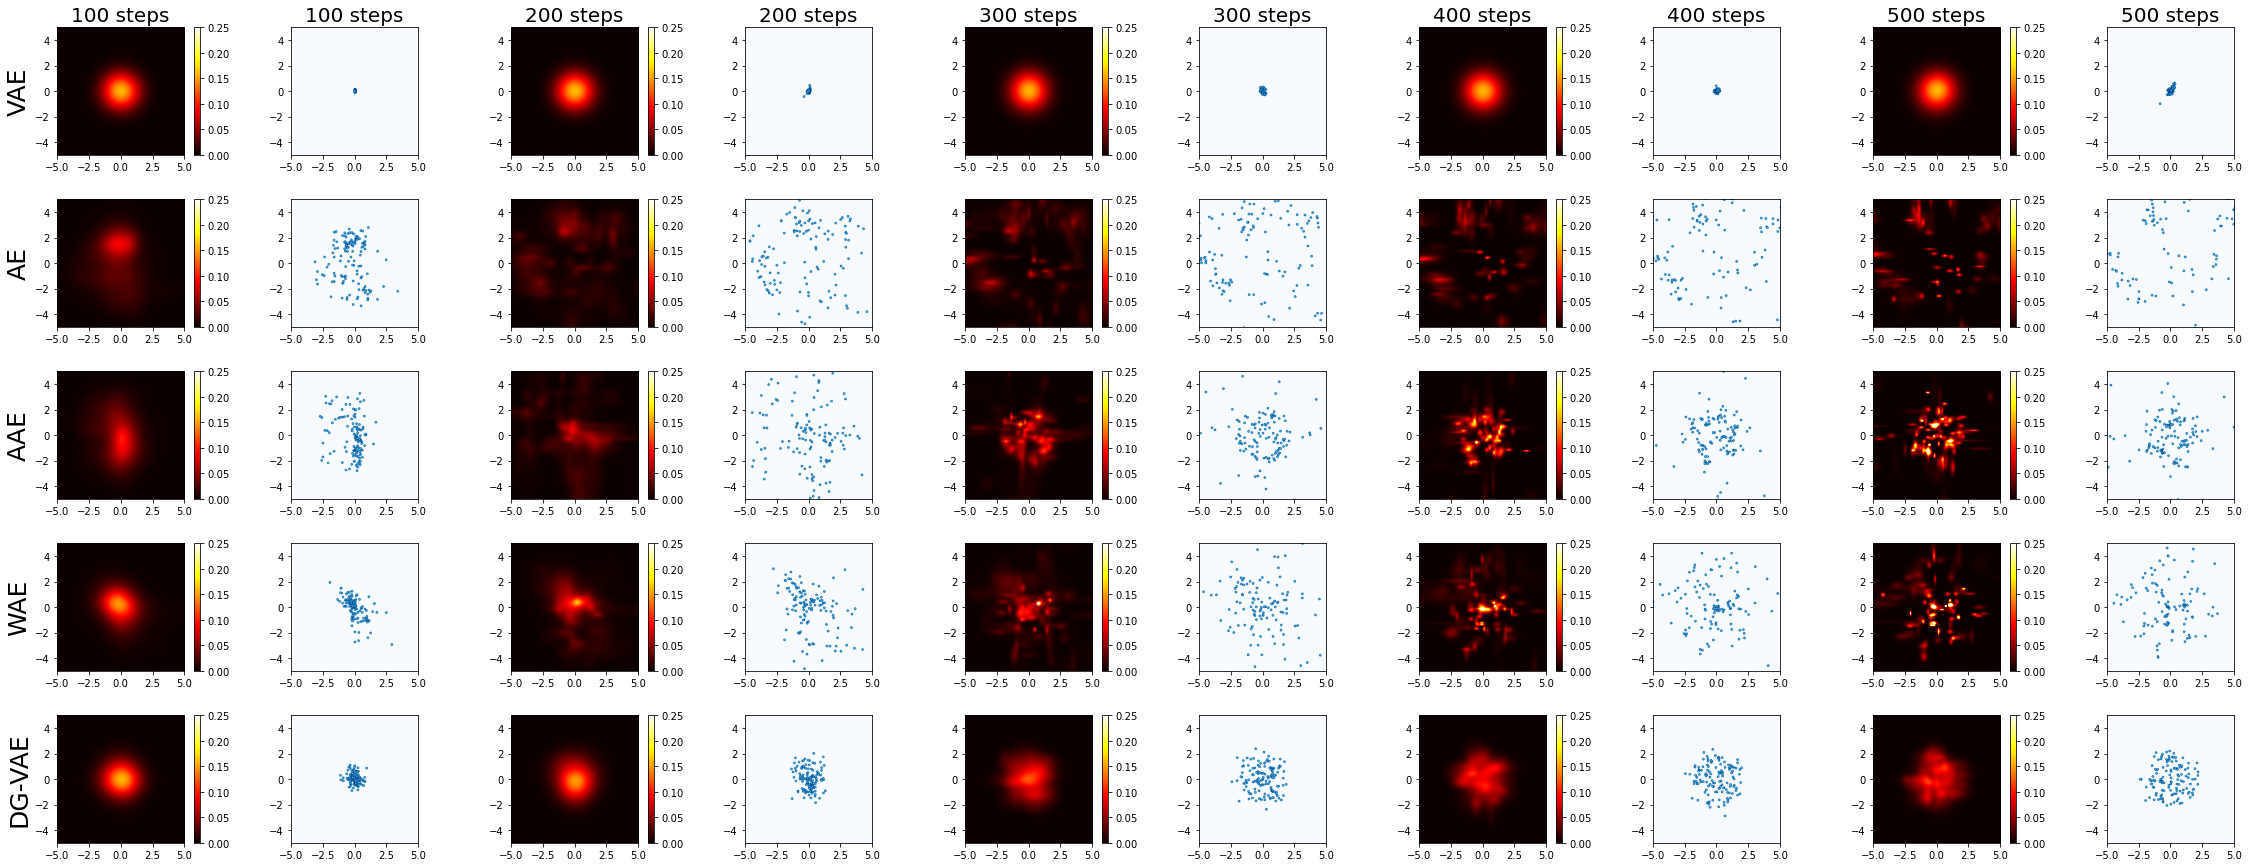

In [11]:
%pdb on
if __name__ == "__main__":
    exp(
        model_class=[vae,ae,aae,wae,dgvae],
        names=["VAE","AE","AAE","WAE","DG-VAE"]
    )